# Spam Ham filter using sklearn 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from textblob import TextBlob
from wordcloud import WordCloud

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<h2 style="color:blue">Data prepration </h2>
download dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/00228

In [3]:
df = pd.read_csv('./data/SMSSpamCollection' , sep='\t' , names=['status', 'message'])

In [4]:
df.head()

,status,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
len(df)

5572

In [6]:
len(df[df.status=='spam'])

747

<h2 style="color:blue">Aggregate statistics analysis of data</h2>
Using pandas and matplotlib we can easily anlaysis the dataset 

In [7]:
df.groupby('status').describe()

message                                                               
         count unique                                                top freq
status                                                                       
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

#### how long the message is ?
getting length of each message=>

In [8]:
df['length'] = df['message'].map(lambda msg:len(msg))
df.head()

,status,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


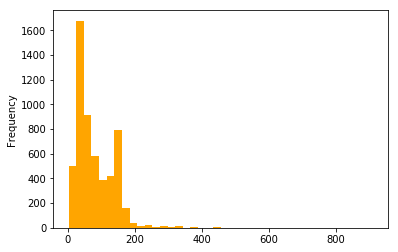

In [35]:
df['length'].plot(bins=40,kind='hist',color='orange')

In [10]:
#describing message length
print(df['length'].describe())

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64


In [11]:
#describing HAM message by length
print('HAM',df['length'].loc[df['status']=='ham'].describe())

('HAM', count    4825.000000
mean       71.558964
std        58.459702
min         2.000000
25%        33.000000
50%        52.000000
75%        93.000000
max       910.000000
Name: length, dtype: float64)


In [12]:
#describing SPAM message by length
print('SPAM',df['length'].loc[df['status']=='spam'].describe())

('SPAM', count    747.000000
mean     139.119143
std       28.998900
min       13.000000
25%      133.000000
50%      149.000000
75%      158.000000
max      224.000000
Name: length, dtype: float64)


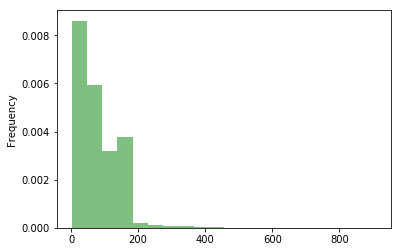

In [13]:
df['length'].plot(kind='hist',bins=20,color='red',facecolor='green',alpha=0.5,normed=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5486b51ed0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5486a42550>], dtype=object)

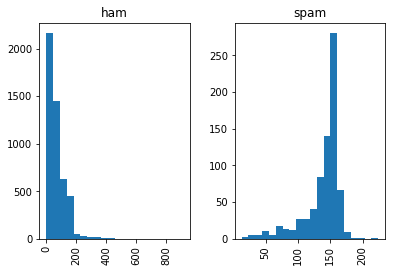

In [14]:
#length difference betwwn SPAM(1) and HAM(0)
df.hist(column='length', by='status', bins=20)

#### getting largest and smallest message

In [15]:
print("Largest messge is:",list(df.message[df.length>900]))  #we can get this 900 from above df.describe
print("Smallest message is ",list(df.message[df.length<3]))  #we can get this 3 from above df.describe

('Largest messge is:', ["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."])
('Smallest message is ', ['Ok', 'Ok', 'Ok', 'Ok'])


### so we can see that most of the SPAM messages are of length 110 to 160

<h2 style="color:blue">Data preprocessing</h2>
It is necessary because we can't apply any Machine learning model on text type data. We we need to tokenize the data.
So we going to conver raw message into vectors.
#### Steps:
1. Split all data into invidual words
2. normalizing data 
3. data to vectors


<p style='color:red'>dependency:</p>
first you need to downlaod **punkt** otherwise it will show you an error.<br>
start python terminal and type<br>
  <code>>>import nltk</code><br>
  <code>>>nltk.download('punkt)</code><br>
  <code>>>nltk.download('wordnet')</code>

#### 1. split into individual words
#### 2.normalize words into their base form which is Lemmatisation
### Lemmatisation of data
The verb ' to go' may appear as 'go', 'goes', 'gone', 'going'. The base form, 'go', that one might look up in a dictionary, is called the lemma for the word.

In [16]:
class Split:
    
    """This class is for spliting data into individual words and lemmatistion of words."""
    
    def into_tokens(self,msg):
        msg = unicode(msg, 'utf8')  # convert bytes into proper unicode
        return TextBlob(msg).words

    def into_lemmas(self,message):
        message = unicode(message, 'utf8').lower()
        words = TextBlob(message).words
        # for each word, take its "base form" = lemma 
        return [word.lemma for word in words]

In [17]:
split = Split()
df.message.head().apply(split.into_tokens)  

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [18]:
df.message.head().apply(split.into_lemmas)
# print(split_into_lemmas("go goes"))

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

#### 3. Getting vectors from data

## What is text feature extraction?
Convert a collection of text documents to a matrix of token counts<br>
Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.


In [19]:
vectorizer = CountVectorizer(analyzer=split.into_lemmas)

In [20]:
#example
X = vectorizer.fit_transform(['hellow','hellow we are back','we we we are back'])
print(X)
# .vocabulary_ gives counts of all words in corpus
print(vectorizer.vocabulary_) 

  (0, 2)	1
  (1, 1)	1
  (1, 0)	1
  (1, 3)	1
  (1, 2)	1
  (2, 1)	1
  (2, 0)	1
  (2, 3)	3
{u'hellow': 2, u'we': 3, u'are': 0, u'back': 1}


In [21]:
X = vectorizer.fit_transform(df['message'])

**getting feature names using vectorizer.get_feature_names**

In [22]:
vectorizer.get_feature_names()[:10]   #printing 10 feature 

[u"''ok",
 u"'an",
 u"'anything",
 u"'comfort",
 u"'d",
 u"'doctors",
 u"'heart",
 u"'help",
 u"'hex",
 u"'hw"]

In [23]:
bag_of_words = vectorizer.fit_transform(df['message'])
X = vectorizer.transform(['win win win this'])
print(bag_of_words.shape,X.shape)

((5572, 8859), (1, 8859))


**Now ***bag_of_word*** contains full SMS coupus in the from of vector**

### Creating weigthage list using tf-idf using scikit-learn's <code>TfidfTransformer</code>
**tf–idf or TFIDF**, is short form of **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Nowadays, tf-idf is one of the most popular term-weighting schemes.[more](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [24]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bag_of_words)
print(tfidf.shape)

(5572, 8859)


In [25]:
df.loc[df["status"]=='ham',"status"]=1
df.loc[df["status"]=='spam',"status"]=0
df['status'] = df['status'].astype('int')

<h2 style="color:blue">Training model</h2>
Now we will train our classifier using numerical message vector.This is very easy using sklearn.<br><br>
We will use **```MultinomialNB```** classifier of sklearn

In [26]:
class Train:
    """Traning and testing our model."""
    
    def __init__(self):
        self.clf = MultinomialNB()
        
    def train(self,x,y):
        self.clf.fit(x,y)
        
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def test(self,y):
        return self.clf.predict(y)
    
    def accuracy(self,x,y):
        acc = accuracy_score(x,y,normalize=False)
        print('accuracy', acc)
        return acc

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf,df['status'],test_size=.1)
clf = Train()
clf.train(X_train,Y_train)

In [28]:
print(clf.score(X_test,Y_test))

0.935483870968


In [29]:
all_predictions = clf.test(tfidf)
print all_predictions
print 'accuracy', accuracy_score(df['status'], all_predictions)
print 'confusion matrix\n', confusion_matrix(df['status'], all_predictions)
print '(row=expected, col=predicted)'

[1 1 0 ..., 1 1 1]
accuracy 0.965003589375
confusion matrix
[[ 552  195]
 [   0 4825]]
(row=expected, col=predicted)


### Testing on some random message string 

In [30]:
message = ['attending workshop']
X = vectorizer.transform(message)
print(X.shape)
clf.test(X)

(1, 8859)


array([1])

<h2 style="color:blue">Creating Word Cloud of Spam and Ham messages</h2>

In [31]:
#spam  = 0 , Ham = 1 generating spam hand ham wordlist
spam_wl = ' '.join(list(df[df['status']==0]['message']))
ham_wl = ' '.join(list(df[df['status']==1]['message']))

In [50]:
spam_wc = WordCloud(background_color='white',width=512,height=512).generate(spam_wl)
ham_wc = WordCloud(background_color='white',width=512,height=512).generate(ham_wl)

<h2 style="color:red">Spam word cloud</h2>

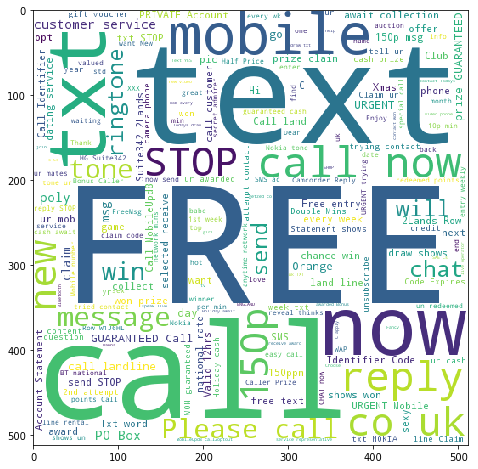

In [51]:
plt.figure(figsize=(10,8))
plt.imshow(spam_wc)

<h2 style="color:green">Ham word cloud</h2>

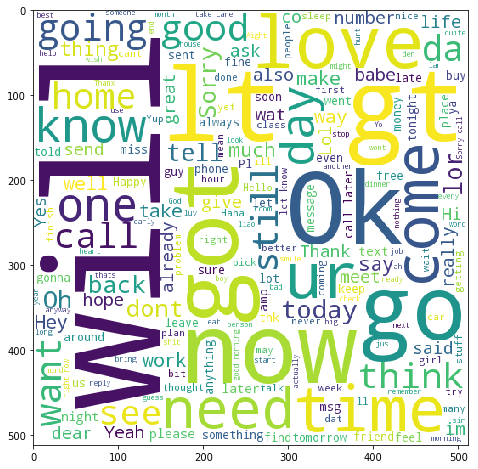

In [53]:
plt.figure(figsize=(10,8))
plt.imshow(ham_wc)